# **TREES** 🌳

this script is for setup, execution, and analysis of the different algorithms that use decision trees

In [150]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import funcs as f
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
from tabulate import tabulate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
'''
Import data from data_organization.ipynb and set random seed

'''

df_all = pd.read_csv('../data/df_all.csv').drop(['Unnamed: 0', 'offset'], axis = 1)
df_gus = pd.read_csv('../data/df_gus.csv').drop(['Unnamed: 0', 'offset'], axis = 1)
df_tgus = pd.read_csv('../data/df_tgus.csv').drop(['Unnamed: 0', 'offset'], axis = 1)
df_tgus_st = pd.read_csv('../data/df_tgus*.csv').drop(['Unnamed: 0', 'offset'], axis = 1)
df_raw = pd.read_csv('../data/df_raw.csv').drop(['Unnamed: 0', 'offset'], axis = 1)
df_us = pd.read_csv('../data/df_us.csv').drop(['Unnamed: 0', 'offset'], axis = 1)

#tree test
#df_all = pd.read_csv('../data/df_tree_test.csv').drop('Unnamed: 0', axis = 1)

np.random.seed(8)

## **bagging**


In [160]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score


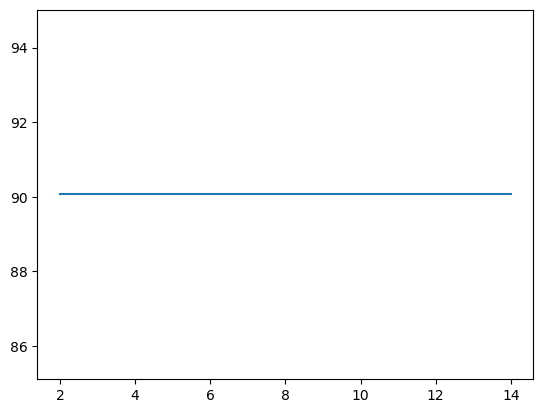

In [161]:
'''
IMPORTANT CONCEPT:

- need to tune tree...find best depth

- cross-validation at each depth is done on 100 different random training sets and the average accuracy at each is recorded

- graph shows best accuracy

- depths w/ new TGUS equation, new data: all - 8, gus - 7, tgus - 8, raw - 9, us - 8

'''

#set train and test data
df_gus=df_gus.sample(frac=1) 
train_proportion = 0.8 
n = len(df_gus)
t = int(train_proportion * n)

# separate training and test sets
y = df_gus['detected']
X = df_gus.loc[:, ~df_gus.columns.isin(['detected'])]

#features in training set
train_x = X.iloc[:t,:].reset_index().iloc[:,1:]
#features in test set
test_x = X.iloc[t:,:].reset_index().iloc[:,1:]
#targets in train set
train_y = pd.Series(y[:t].reset_index().iloc[:,1:].iloc[:,0])
#targets in test set
test_y = pd.Series(y[t:].reset_index().iloc[:,1:].iloc[:,0])

# define the depths
depths = np.arange(2,15)
# create an empty data frame for our results
results = np.zeros(len(depths))

for i in range(100):
    for j in range(len(depths)):
        best_depth_tree = DecisionTreeClassifier(max_depth = depths[j]) # creating an instance of a decision tree
        results[j%13] += cross_val_score(best_depth_tree, train_x, 
                                    train_y, scoring="accuracy", # getting the cv accuracy metric for the tree at each depth
                    cv=6).mean()
        
                        

test = pd.DataFrame({'depths':depths, 'accuracy':results})
test.sort_values("accuracy", ascending=False)
plt.plot(test.depths, test.accuracy)

In [169]:
# define tree IF all the same
all_depth = 8
gus_depth = 8
tgus_depth = 9
raw_depth = 9
us_depth = 8
rs = 42
#clf = GradientBoostingClassifier(n_estimators = 100, max_depth = 3)

# final df for display
dfr = pd.DataFrame(index=['All', 'GUS Alone', 'TGUS Alone', 'US Focus'], columns=['Avg. Train %', 'Avg. Validation %', 'Avg. Test %',
                                                                                   'Best Sc. Train %', 'Best Sc. Validation %', 'Best Sc. Test %'])

In [121]:
'''
Considering GUS, TGUS, TGUS*, and raw values with other features

'''
clf = GradientBoostingClassifier(n_estimators = 100, max_depth = all_depth, random_state= rs)
all_train =[]
all_vals =[]
all_tests=[]
fi_all = np.zeros((len(df_all.columns) - 1))
for i in range(50):
    model, train_acc, val_acc, test_acc = f.kfold_crossval(df_all, clf, 'bagging')
    all_train = np.append(train_acc, all_train)
    all_vals = np.append(val_acc, all_vals)
    all_tests = np.append(test_acc, all_tests)
    fi_all += model.feature_importances_

    # keep best model
    if test_acc >= np.max(all_tests):
        all_model = model
        all_train_best = train_acc
        all_val_best = val_acc
        all_test_best = test_acc

# keep feature importances
fi_all /= 50

# get average accuracies
all_train_avg = round(np.mean(all_train),1)
all_vals_avg = round(np.mean(all_vals),1)
all_tests_avg = round(np.mean(all_tests),1)

print('All - Results:')
print(f'Best Scenario Training Accuracy: {all_train_best}%')
print(f'Average Training Accuracy: {all_train_avg}%')
print(f'Best Scenario Validation Accuracy: {all_val_best}%')
print(f'Average Validation Accuracy: {all_vals_avg}%')
print(f'Best Scenario Test Accuracy: {all_test_best}%')
print(f'Average Test Accuracy: {all_tests_avg}%')

All - Results:
Best Scenario Training Accuracy: 96.2%
Average Training Accuracy: 97.3%
Best Scenario Validation Accuracy: 97.4%
Average Validation Accuracy: 95.7%
Best Scenario Test Accuracy: 98.7%
Average Test Accuracy: 94.2%


In [163]:
'''
Considering just GUS with other features

'''
clf = GradientBoostingClassifier(n_estimators = 100, max_depth = gus_depth, random_state= rs)
gus_train =[]
gus_vals =[]
gus_tests=[]
fi_gus = np.zeros((len(df_gus.columns) - 1))
for i in range(50):
    model, train_acc, val_acc, test_acc = f.kfold_crossval(df_gus, clf, 'bagging')
    gus_train = np.append(train_acc, gus_train)
    gus_vals = np.append(val_acc, gus_vals)
    gus_tests = np.append(test_acc, gus_tests)
    fi_gus += model.feature_importances_

    # keep best model
    if test_acc >= np.max(gus_tests):
        gus_model = model
        gus_train_best = train_acc
        gus_val_best = val_acc
        gus_test_best = test_acc

# keep feature importances
fi_gus /= 50

# get average accuracies
gus_train_avg = round(np.mean(gus_train),1)
gus_vals_avg = round(np.mean(gus_vals),1)
gus_tests_avg = round(np.mean(gus_tests),1)

print('GUS - Results:')
print(f'Best Scenario Training Accuracy: {gus_train_best}%')
print(f'Average Training Accuracy: {gus_train_avg}%')
print(f'Best Scenario Validation Accuracy: {gus_val_best}%')
print(f'Average Validation Accuracy: {gus_vals_avg}%')
print(f'Best Scenario Test Accuracy: {gus_test_best}%')
print(f'Average Test Accuracy: {gus_tests_avg}%')


GUS - Results:
Best Scenario Training Accuracy: 90.2%
Average Training Accuracy: 90.7%
Best Scenario Validation Accuracy: 89.7%
Average Validation Accuracy: 92.8%
Best Scenario Test Accuracy: 93.7%
Average Test Accuracy: 89.5%


In [158]:
'''
Considering just TGUS with other features

'''
clf = GradientBoostingClassifier(n_estimators = 100, max_depth = tgus_depth, random_state= rs)
tgus_train =[]
tgus_vals =[]
tgus_tests=[]
fi_tgus = np.zeros((len(df_tgus.columns) - 1))
for i in range(50):
    model, train_acc, val_acc, test_acc = f.kfold_crossval(df_tgus, clf, 'bagging')
    tgus_train = np.append(train_acc, tgus_train)
    tgus_vals = np.append(val_acc, tgus_vals)
    tgus_tests = np.append(test_acc, tgus_tests)
    fi_tgus += model.feature_importances_

    # keep best model
    if test_acc >= np.max(tgus_tests):
        tgus_model = model
        tgus_train_best = train_acc
        tgus_val_best = val_acc
        tgus_test_best = test_acc

# keep feature importances
fi_tgus /= 50

# get average accuracies
tgus_train_avg = round(np.mean(tgus_train),1)
tgus_vals_avg = round(np.mean(tgus_vals),1)
tgus_tests_avg = round(np.mean(tgus_tests),1)

print('TGUS - Results:')
print(f'Best Scenario Training Accuracy: {tgus_train_best}%')
print(f'Average Training Accuracy: {tgus_train_avg}%')
print(f'Best Scenario Validation Accuracy: {tgus_val_best}%')
print(f'Average Validation Accuracy: {tgus_vals_avg}%')
print(f'Best Scenario Test Accuracy: {tgus_test_best}%')
print(f'Average Test Accuracy: {tgus_tests_avg}%')

TGUS - Results:
Best Scenario Training Accuracy: 95.7%
Average Training Accuracy: 97.0%
Best Scenario Validation Accuracy: 96.2%
Average Validation Accuracy: 95.8%
Best Scenario Test Accuracy: 98.7%
Average Test Accuracy: 93.1%


In [124]:
'''
Considering just TGUS* and raw values with other features


tgus_st_train =[]
tgus_st_vals =[]
tgus_st_tests=[]
for i in range(100):
    model, train_acc, val_acc, test_acc = f.kfold_crossval(df_tgus_st, clf, 'bagging')
    tgus_st_train = np.append(train_acc, tgus_st_train)
    tgus_st_vals = np.append(val_acc, tgus_st_vals)
    tgus_st_tests = np.append(test_acc, tgus_st_tests)

    # keep best model
    if test_acc >= np.max(tgus_st_tests):
        tgus_st_model = model
        tgus_st_train_acc = train_acc
        tgus_st_val_acc = val_acc
        tgus_st_test_acc = test_acc

print('TGUS* - Results:')
print(f'Best Scenario Training Accuracy: {tgus_st_train_acc}%')
print(f'Average Training Accuracy: {round(np.mean(tgus_st_train),1)}%')
print(f'Best Scenario Validation Accuracy: {tgus_st_val_acc}%')
print(f'Average Validation Accuracy: {round(np.mean(tgus_st_vals),1)}%')
print(f'Best Scenario Test Accuracy: {tgus_st_test_acc}%')
print(f'Average Test Accuracy: {round(np.mean(tgus_st_tests),1)}%')
'''

"\nConsidering just TGUS* and raw values with other features\n\n\ntgus_st_train =[]\ntgus_st_vals =[]\ntgus_st_tests=[]\nfor i in range(100):\n    model, train_acc, val_acc, test_acc = f.kfold_crossval(df_tgus_st, clf, 'bagging')\n    tgus_st_train = np.append(train_acc, tgus_st_train)\n    tgus_st_vals = np.append(val_acc, tgus_st_vals)\n    tgus_st_tests = np.append(test_acc, tgus_st_tests)\n\n    # keep best model\n    if test_acc >= np.max(tgus_st_tests):\n        tgus_st_model = model\n        tgus_st_train_acc = train_acc\n        tgus_st_val_acc = val_acc\n        tgus_st_test_acc = test_acc\n\nprint('TGUS* - Results:')\nprint(f'Best Scenario Training Accuracy: {tgus_st_train_acc}%')\nprint(f'Average Training Accuracy: {round(np.mean(tgus_st_train),1)}%')\nprint(f'Best Scenario Validation Accuracy: {tgus_st_val_acc}%')\nprint(f'Average Validation Accuracy: {round(np.mean(tgus_st_vals),1)}%')\nprint(f'Best Scenario Test Accuracy: {tgus_st_test_acc}%')\nprint(f'Average Test Accura

In [125]:
'''
Considering just raw values with other features

clf = GradientBoostingClassifier(n_estimators = 100, max_depth = raw_depth, random_state= rs)
raw_train =[]
raw_vals =[]
raw_tests=[]
fi_raw = np.zeros((len(df_raw.columns) - 1))
for i in range(50):
    model, train_acc, val_acc, test_acc = f.kfold_crossval(df_raw, clf, 'bagging')
    raw_train = np.append(train_acc, raw_train)
    raw_vals = np.append(val_acc, raw_vals)
    raw_tests = np.append(test_acc, raw_tests)
    fi_raw += model.feature_importances_

    # keep best model
    if test_acc >= np.max(raw_tests):
        raw_model = model
        raw_train_best = train_acc
        raw_val_best = val_acc
        raw_test_best = test_acc

# keep feature importances
fi_raw /= 50

# get average accuracies
raw_train_avg = round(np.mean(raw_train),1)
raw_vals_avg = round(np.mean(raw_vals),1)
raw_tests_avg = round(np.mean(raw_tests),1)

print('Raw - Results:')
print(f'Best Scenario Training Accuracy: {raw_train_best}%')
print(f'Average Training Accuracy: {raw_train_avg}%')
print(f'Best Scenario Validation Accuracy: {raw_val_best}%')
print(f'Average Validation Accuracy: {raw_vals_avg}%')
print(f'Best Scenario Test Accuracy: {raw_test_best}%')
print(f'Average Test Accuracy: {raw_tests_avg}%')

'''

"\nConsidering just raw values with other features\n\nclf = GradientBoostingClassifier(n_estimators = 100, max_depth = raw_depth, random_state= rs)\nraw_train =[]\nraw_vals =[]\nraw_tests=[]\nfi_raw = np.zeros((len(df_raw.columns) - 1))\nfor i in range(50):\n    model, train_acc, val_acc, test_acc = f.kfold_crossval(df_raw, clf, 'bagging')\n    raw_train = np.append(train_acc, raw_train)\n    raw_vals = np.append(val_acc, raw_vals)\n    raw_tests = np.append(test_acc, raw_tests)\n    fi_raw += model.feature_importances_\n\n    # keep best model\n    if test_acc >= np.max(raw_tests):\n        raw_model = model\n        raw_train_best = train_acc\n        raw_val_best = val_acc\n        raw_test_best = test_acc\n\n# keep feature importances\nfi_raw /= 50\n\n# get average accuracies\nraw_train_avg = round(np.mean(raw_train),1)\nraw_vals_avg = round(np.mean(raw_vals),1)\nraw_tests_avg = round(np.mean(raw_tests),1)\n\nprint('Raw - Results:')\nprint(f'Best Scenario Training Accuracy: {raw_tr

In [147]:
'''
Considering just US with other features

'''
clf = GradientBoostingClassifier(n_estimators = 100, max_depth = us_depth, random_state= rs)
us_train =[]
us_vals =[]
us_tests=[]
fi_us = np.zeros((len(df_us.columns) - 1))
for i in range(50):
    model, train_acc, val_acc, test_acc = f.kfold_crossval(df_us, clf, 'bagging')
    us_train = np.append(train_acc, us_train)
    us_vals = np.append(val_acc, us_vals)
    us_tests = np.append(test_acc, us_tests)
    fi_us += model.feature_importances_

    # keep best model
    if test_acc >= np.max(us_tests):
        us_model = model
        us_train_best = train_acc
        us_val_best = val_acc
        us_test_best = test_acc

# keep feature importances
fi_us /= 50

# get average accuracies
us_train_avg = round(np.mean(us_train),1)
us_vals_avg = round(np.mean(us_vals),1)
us_tests_avg = round(np.mean(us_tests),1)

print('US - Results:')
print(f'Best Scenario Training Accuracy: {us_train_best}%')
print(f'Average Training Accuracy: {us_train_avg}%')
print(f'Best Scenario Validation Accuracy: {us_val_best}%')
print(f'Average Validation Accuracy: {us_vals_avg}%')
print(f'Best Scenario Test Accuracy: {us_test_best}%')
print(f'Average Test Accuracy: {us_tests_avg}%')


US - Results:
Best Scenario Training Accuracy: 96.2%
Average Training Accuracy: 97.2%
Best Scenario Validation Accuracy: 97.4%
Average Validation Accuracy: 96.5%
Best Scenario Test Accuracy: 98.7%
Average Test Accuracy: 93.6%


In [172]:
# fill results table
dfr.loc['All',:] = [all_train_avg, all_vals_avg, all_tests_avg, all_train_best, all_val_best, all_test_best]
dfr.loc['GUS Alone',:] = [gus_train_avg, gus_vals_avg, gus_tests_avg, gus_train_best, gus_val_best, gus_test_best]
dfr.loc['TGUS Alone',:] = [tgus_train_avg, tgus_vals_avg, tgus_tests_avg, tgus_train_best, tgus_val_best, tgus_test_best]
dfr.loc['US Focus',:] = [us_train_avg, us_vals_avg, us_tests_avg, us_train_best, us_val_best, us_test_best]

print(tabulate(dfr.loc[['GUS Alone', 'TGUS Alone'],:], headers='keys', tablefmt = 'fancy_grid', numalign = 'center'))

╒════════════╤════════════════╤═════════════════════╤═══════════════╤════════════════════╤═════════════════════════╤═══════════════════╕
│            │  Avg. Train %  │  Avg. Validation %  │  Avg. Test %  │  Best Sc. Train %  │  Best Sc. Validation %  │  Best Sc. Test %  │
╞════════════╪════════════════╪═════════════════════╪═══════════════╪════════════════════╪═════════════════════════╪═══════════════════╡
│ GUS Alone  │      90.7      │        92.8         │     89.5      │        90.2        │          89.7           │       93.7        │
├────────────┼────────────────┼─────────────────────┼───────────────┼────────────────────┼─────────────────────────┼───────────────────┤
│ TGUS Alone │       97       │        95.8         │     93.1      │        95.7        │          96.2           │       98.7        │
╘════════════╧════════════════╧═════════════════════╧═══════════════╧════════════════════╧═════════════════════════╧═══════════════════╛


/var/folders/31/n7d1lkjj6y1_lcp76m8nrtbh0000gn/T/ipykernel_92707/10968264.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  axUS=sns.barplot(ax=axUS,x=np.array(fi_us.loc[:]), y= np.vectorize(lambda k: y_dict[k])(arr), palette = pal)
/var/folders/31/n7d1lkjj6y1_lcp76m8nrtbh0000gn/T/ipykernel_92707/10968264.py:20: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  axUS=sns.barplot(ax=axUS,x=np.array(fi_us.loc[:]), y= np.vectorize(lambda k: y_dict[k])(arr), palette = pal)
/var/folders/31/n7d1lkjj6y1_lcp76m8nrtbh0000gn/T/ipykernel_92707/10968264.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  axTGUS=sns.barplot(ax=axTGUS,x=np.array(fi_tgus.loc[:]), y= np.vectorize(

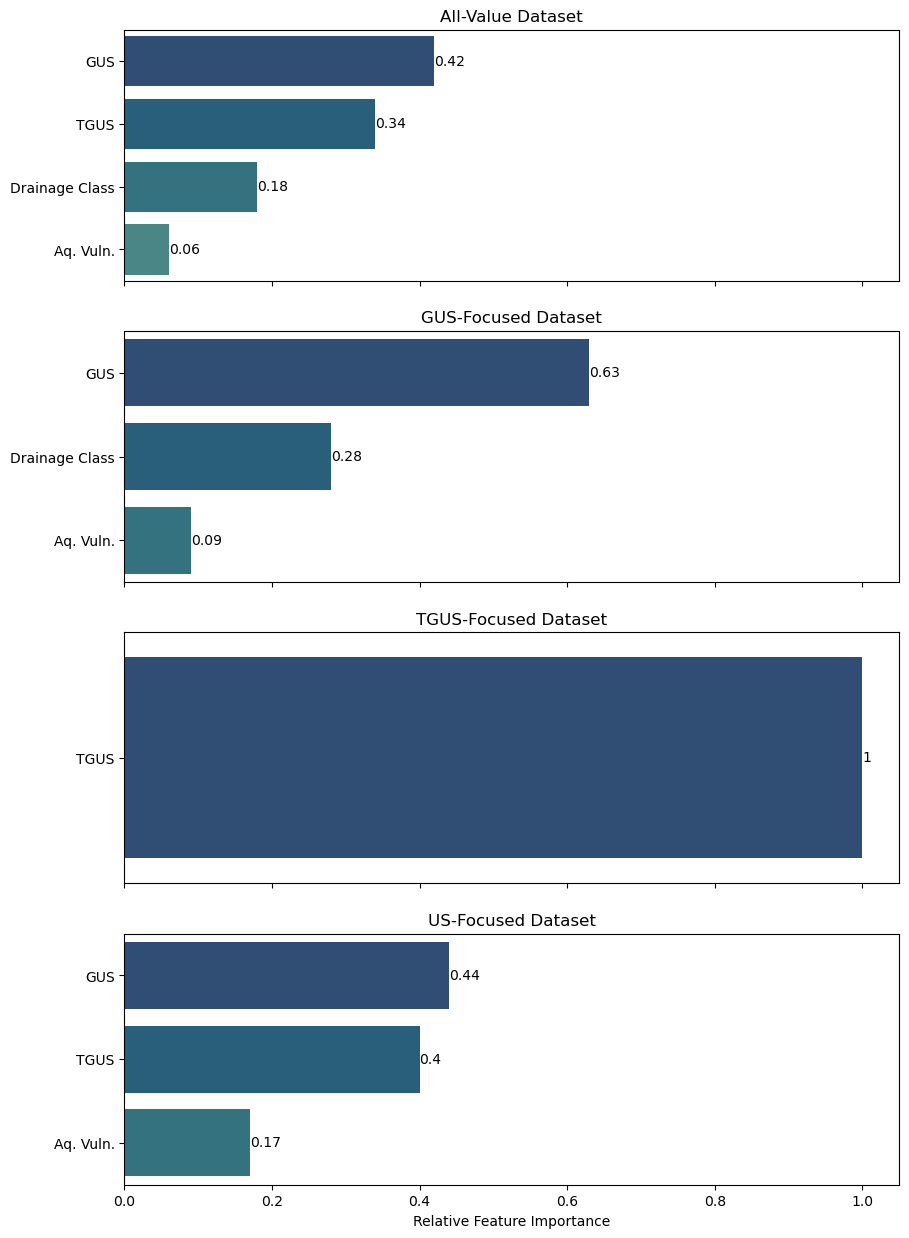

In [156]:
'''setup figures for plotting'''
fig, ([axAll, axGUS, axTGUS, axUS]) = plt.subplots(nrows=4, ncols=1, figsize =(10,15), sharex = True)

axGUS.set_title('GUS-Focused Dataset',fontsize=12)
axTGUS.set_title('TGUS-Focused Dataset',fontsize=12)
axAll.set_title('All-Value Dataset',fontsize=12)
axUS.set_title('US-Focused Dataset',fontsize=12)


y_dict = {'detlimit': 'Detection Limit', 'gus': 'GUS', 'koc [m^3/Mg]':'Partition Coefficient', 'tgus':'TGUS', 'medium':'Medium Aq. Vuln.', 'soil_halflife': 'Soil Half-life', 
        'high':'High Aq. Vuln.', 'Poorly drained':'Poorly Drained', 'Well drained':'Well Drained', 'Moderately well drained':'Moderately Well Drained', 
        'Somewhat poorly drained':'Somewhat Poorly Drained', 'low':'Low Aq. Vuln.', 'Very poorly drained':'Very Poorly Drained', 'Somewhat excessively drained':'Somewhat Excessively Drained',
        'offset':'Offset', 'aquifer_vulnerability': 'Aq. Vuln.', 'drainage_class':'Drainage Class'}

pal = sns.color_palette('crest_r')

fi_us = pd.Series(np.round(fi_us,2), index = df_us.drop('detected', axis = 1).columns)
fi_us = fi_us.sort_values(ascending=False)
arr=np.array(fi_us.index)
axUS=sns.barplot(ax=axUS,x=np.array(fi_us.loc[:]), y= np.vectorize(lambda k: y_dict[k])(arr), palette = pal)
for i in axUS.containers:
    axUS.bar_label(i,)

fi_tgus = pd.Series(np.round(fi_tgus,2), index = df_tgus.drop('detected', axis = 1).columns)
fi_tgus = fi_tgus.sort_values(ascending=False)
arr=np.array(fi_tgus.index)
axTGUS=sns.barplot(ax=axTGUS,x=np.array(fi_tgus.loc[:]), y= np.vectorize(lambda k: y_dict[k])(arr), palette = pal)
for i in axTGUS.containers:
    axTGUS.bar_label(i,)

fi_gus = pd.Series(np.round(fi_gus,2), index = df_gus.drop('detected', axis = 1).columns)
fi_gus = fi_gus.sort_values(ascending=False)
arr=np.array(fi_gus.index)
axGUS=sns.barplot(ax=axGUS,x=np.array(fi_gus.loc[:]), y= np.vectorize(lambda k: y_dict[k])(arr),palette = pal)
for i in axGUS.containers:
    axGUS.bar_label(i,)

fi_all = pd.Series(np.round(fi_all,2), index = df_all.drop('detected', axis = 1).columns)
fi_all = fi_all.sort_values(ascending=False)
arr=np.array(fi_all.index)
axAll=sns.barplot(ax=axAll,x=np.array(fi_all.loc[:]), y= np.vectorize(lambda k: y_dict[k])(arr), palette = pal)
axUS.set_xlabel('Relative Feature Importance')
for i in axAll.containers:
    axAll.bar_label(i,)



In [129]:
'''
Equal variance t-tests to compare result means
'''
cols = ['All', 'GUS', 'TGUS', 'Raw']
train_scores = pd.DataFrame({'All': all_train, 'GUS': gus_train, 'TGUS': tgus_train, 'Raw': raw_train})
val_scores = pd.DataFrame({'All': all_vals, 'GUS': gus_vals, 'TGUS': tgus_vals, 'Raw': raw_vals})
test_scores = pd.DataFrame({'All': all_tests, 'GUS': gus_tests, 'TGUS': tgus_tests, 'Raw': raw_tests})

comp_train = pd.DataFrame(columns = train_scores.columns, index = train_scores.columns )
comp_val = pd.DataFrame(columns = train_scores.columns, index = train_scores.columns )
comp_test = pd.DataFrame(columns = train_scores.columns, index = train_scores.columns )

for i in cols:
    for j in cols:
        stat_train,p_train = sts.ttest_ind(train_scores.loc[:,i], train_scores.loc[:,j], equal_var = True, alternative = 'two-sided')
        comp_train.loc[i,j] = [round(p_train,100)]

        stat_val,p_val = sts.ttest_ind(val_scores.loc[:,i], val_scores.loc[:,j], equal_var = True, alternative = 'two-sided')
        comp_val.loc[i,j] = [round(p_val,100)]

        stat_test,p_test = sts.ttest_ind(test_scores.loc[:,i], test_scores.loc[:,j], equal_var = True, alternative = 'two-sided')
        comp_test.loc[i,j] = [round(p_test,100)]

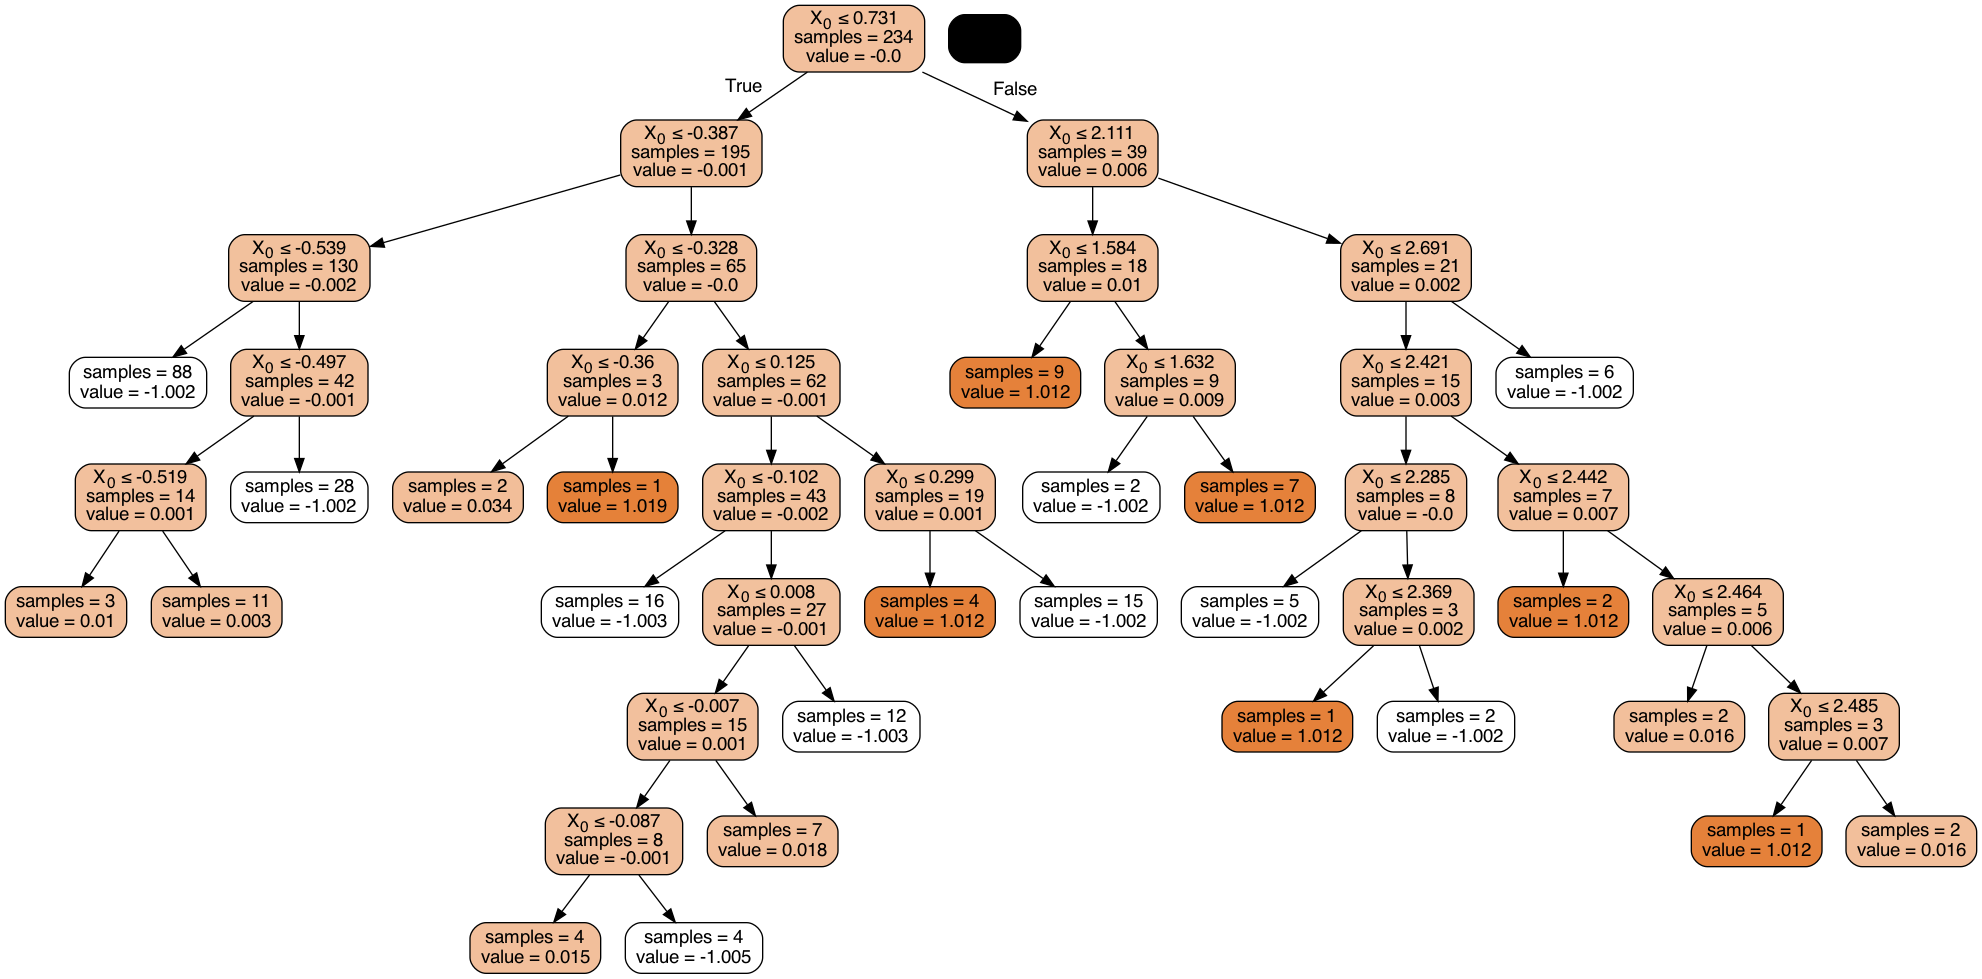

In [157]:
# Get the tree number 42
sub_tree_42 = tgus_model.estimators_[42, 0]

# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
from sklearn.tree import export_graphviz
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)
graph = graph_from_dot_data(dot_data)
png = graph.create_png()
Image(png)